In [0]:
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from functools import reduce
from pyspark.sql import DataFrame
import pyspark.sql.functions as F
from IPython.display import Image, display
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
import pandas as pd
import numpy as np

In [0]:
# Creates a new directory at the specified DBFS
dbutils.fs.mkdirs("dbfs:/FileStore/parquets/")

Out[2]: True

In [0]:
files = dbutils.fs.ls("dbfs:/FileStore/tables/")
display(files)

[FileInfo(path='dbfs:/FileStore/tables/01_EDA_experiment-1.ipynb', name='01_EDA_experiment-1.ipynb', size=1294525, modificationTime=1746013161000),
 FileInfo(path='dbfs:/FileStore/tables/01_EDA_experiment.ipynb', name='01_EDA_experiment.ipynb', size=1294525, modificationTime=1746012054000),
 FileInfo(path='dbfs:/FileStore/tables/2025_03_11_Starting_Step_for_Streaming.ipynb', name='2025_03_11_Starting_Step_for_Streaming.ipynb', size=7008, modificationTime=1742055139000),
 FileInfo(path='dbfs:/FileStore/tables/2025_03_11___DBFS_Example_Classifier.ipynb', name='2025_03_11___DBFS_Example_Classifier.ipynb', size=68203, modificationTime=1742055138000),
 FileInfo(path='dbfs:/FileStore/tables/2025_03_11___DBFS_Example_Clustering.ipynb', name='2025_03_11___DBFS_Example_Clustering.ipynb', size=106444, modificationTime=1742055138000),
 FileInfo(path='dbfs:/FileStore/tables/2025_03_11___DBFS_Example_Regression.ipynb', name='2025_03_11___DBFS_Example_Regression.ipynb', size=69505, modificationTime=

In [0]:
for f in files:
    if f.path.endswith(".parquet"):
        name = f.name
        dbutils.fs.mv(f.path, f"dbfs:/FileStore/parquets/{name}")

In [0]:
parquets = dbutils.fs.ls("dbfs:/FileStore/parquets/")
display(parquets)

[FileInfo(path='dbfs:/FileStore/parquets/full_dataset_after_eda.parquet/', name='full_dataset_after_eda.parquet/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/parquets/yellow_tripdata_2022_01.parquet', name='yellow_tripdata_2022_01.parquet', size=38139949, modificationTime=1746799834000),
 FileInfo(path='dbfs:/FileStore/parquets/yellow_tripdata_2022_02.parquet', name='yellow_tripdata_2022_02.parquet', size=45616512, modificationTime=1746799838000),
 FileInfo(path='dbfs:/FileStore/parquets/yellow_tripdata_2022_03.parquet', name='yellow_tripdata_2022_03.parquet', size=55682369, modificationTime=1746799843000),
 FileInfo(path='dbfs:/FileStore/parquets/yellow_tripdata_2022_04.parquet', name='yellow_tripdata_2022_04.parquet', size=55222692, modificationTime=1746799847000),
 FileInfo(path='dbfs:/FileStore/parquets/yellow_tripdata_2022_05.parquet', name='yellow_tripdata_2022_05.parquet', size=55558821, modificationTime=1746799852000),
 FileInfo(path='dbfs:/FileStore/parquets/

In [0]:
# for f in parquets:
#     if f.path.endswith(".parquet"):
#         dbutils.fs.rm(f.path)
#         print(f"Deleted: {f.path}")

In [0]:
# Iniciar Spark
# findspark.init()
# spark = SparkSession.builder.appName("NYC Taxi 2024").getOrCreate()

#

In [0]:
# List for all the parquet files 
file_paths = [f.path for f in parquets if f.path.endswith(".parquet")]

In [0]:
file_paths

Out[9]: ['dbfs:/FileStore/parquets/yellow_tripdata_2022_01.parquet',
 'dbfs:/FileStore/parquets/yellow_tripdata_2022_02.parquet',
 'dbfs:/FileStore/parquets/yellow_tripdata_2022_03.parquet',
 'dbfs:/FileStore/parquets/yellow_tripdata_2022_04.parquet',
 'dbfs:/FileStore/parquets/yellow_tripdata_2022_05.parquet',
 'dbfs:/FileStore/parquets/yellow_tripdata_2022_06.parquet',
 'dbfs:/FileStore/parquets/yellow_tripdata_2022_07.parquet',
 'dbfs:/FileStore/parquets/yellow_tripdata_2022_08.parquet',
 'dbfs:/FileStore/parquets/yellow_tripdata_2022_09.parquet',
 'dbfs:/FileStore/parquets/yellow_tripdata_2022_10.parquet',
 'dbfs:/FileStore/parquets/yellow_tripdata_2022_11.parquet',
 'dbfs:/FileStore/parquets/yellow_tripdata_2022_12.parquet',
 'dbfs:/FileStore/parquets/yellow_tripdata_2023_01.parquet',
 'dbfs:/FileStore/parquets/yellow_tripdata_2023_02.parquet',
 'dbfs:/FileStore/parquets/yellow_tripdata_2023_03.parquet',
 'dbfs:/FileStore/parquets/yellow_tripdata_2023_04.parquet',
 'dbfs:/FileStor

In [0]:
# Function to extract the month from the filename
def extract_year_month(filename):
    filename= filename.replace('.parquet','') # To remove .parquet

    # Get the file name from the full path
    file_name = filename.split('/')[-1]  # ex: 'yellow_tripdata_2024_01'

    # Then split the name
    name_split= file_name.split('_')

    # Get the year and month
    year= name_split[2]
    month= name_split[3]
    
    return year,month

In [0]:
# Loads the files and adds the 'month' column
dfs = []
for path in file_paths:
    year, month = extract_year_month(path)
    df = spark.read.parquet(path)
    df = df.withColumn("month", F.lit(int(month)))  # adds the column month
    df= df.withColumn("year", F.lit(int(year))) 
    dfs.append(df)

In [0]:
# Joins everything into a single DataFrame
full_df = reduce(DataFrame.unionByName, dfs)

In [0]:
full_df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----+----+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|month|year|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----+----+
|       1| 2022-01-01 00:35:40|  2022-01-01 00:53:29|            2.0|          3.8|       1.0|                 N|         142|         236|           1|  

In [0]:
# Check the result
print(f"Total rows: {full_df.count()}")
print(f"Columns: {full_df.columns}")

Total rows: 119136044
Columns: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee', 'month', 'year']


In [0]:
display(Image(filename="/FileStore/tables/figura.png"))

---------------------------------------------------------------------------
FileNotFoundError                         Traceback (most recent call last)
File <command-631740233671429>:1
----> 1 display(Image(filename="/FileStore/tables/figura.png"))

File /databricks/python/lib/python3.9/site-packages/IPython/core/display.py:957, in Image.__init__(self, data, url, filename, format, embed, width, height, retina, unconfined, metadata, alt)
    955 self.unconfined = unconfined
    956 self.alt = alt
--> 957 super(Image, self).__init__(data=data, url=url, filename=filename,
    958         metadata=metadata)
    960 if self.width is None and self.metadata.get('width', {}):
    961     self.width = metadata['width']

File /databricks/python/lib/python3.9/site-packages/IPython/core/display.py:327, in DisplayObject.__init__(self, data, url, filename, metadata)
    324 elif self.metadata is None:
    325     self.metadata = {}
--> 327 self.reload()
    328 self._check_data()

File /databricks/p

# EDA

In [0]:
# See the schema (column names and types)
full_df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)
 |-- month: integer (nullable = false)
 |-- year: integer (nullable = false)



In [0]:
#all the collumns that have type double (continuous variables)
continuous_cols = [
    "trip_distance", "fare_amount", "tip_amount", "total_amount",
    "extra", "mta_tax", "tolls_amount", "improvement_surcharge",
    "congestion_surcharge", "airport_fee"
]

In [0]:
# Get descriptive statistics from Spark
desc_df = full_df.select(continuous_cols).describe()

# Convert to pandas for nice formatting
desc_pd = desc_df.toPandas().set_index("summary").T

# Round values and display nicely

pd.set_option("display.max_columns", None)
display(desc_pd.round(2))

summary,count,mean,stddev,min,max
trip_distance,119136044,5.018125657756097,446.04888573457214,0.0,398608.62
fare_amount,119136044,16.385721683690377,12882.321816671303,-1.33391414E8,401092.32
tip_amount,119136044,4.683986916336596,12882.046863864049,-411.0,1.3339136353E8
total_amount,119136044,25.9841638083848,84.37535942749156,-2567.8,401095.62
extra,119136044,1.3146900143838929,1.9112348878262777,-39.17,10002.5
mta_tax,119136044,0.48466054261462993,0.1125160278418659,-0.55,53.16
tolls_amount,119136044,0.5621950783422671,2.1639867775164627,-140.63,1702.88
improvement_surcharge,119136044,0.7529654728221258,0.3688632007735949,-1.0,2.0
congestion_surcharge,112367153,2.2596308822561344,0.8091722948780162,-2.5,2.75
airport_fee,112367153,0.12782487645655666,0.44161732146194743,-1.75,1.75


In [0]:
# Check for nulls in all columns (absolute and percentage)
print("\nNull values per column (%):")

total_rows = full_df.count()

for col in full_df.columns:
    nulls = full_df.filter(F.col(col).isNull()).count()
    if nulls > 0:
        percentage = (nulls / total_rows) * 100
        print(f"{col}: {nulls} nulls ({percentage:.2f}%)")


Null values per column (%):
passenger_count: 6768891 nulls (5.68%)
RatecodeID: 6768891 nulls (5.68%)
store_and_fwd_flag: 6768891 nulls (5.68%)
congestion_surcharge: 6768891 nulls (5.68%)
airport_fee: 6768891 nulls (5.68%)


In [0]:
same_nulls = full_df.filter(
    F.col("passenger_count").isNull() & 
    F.col("RatecodeID").isNull() &
    F.col("store_and_fwd_flag").isNull() &
    F.col("congestion_surcharge").isNull() &
    F.col("Airport_fee").isNull()
)

same_nulls.count()

Out[20]: 6768891

Since we have rows without a lot of information we can delete them

In [0]:
same_nulls.limit(100).toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,month,year
0,2,2022-01-01 00:50:00,2022-01-01 00:54:00,NaN,1.00,NaN,None,68,246,0,13.20,0.0,0.5,1.75,0.0,0.3,18.25,NaN,NaN,1,2022
1,2,2022-01-01 00:49:24,2022-01-01 01:27:36,NaN,13.31,NaN,None,257,223,0,44.87,0.0,0.5,10.05,0.0,0.3,55.72,NaN,NaN,1,2022
2,2,2022-01-01 00:42:00,2022-01-01 00:56:00,NaN,2.87,NaN,None,143,236,0,13.23,0.0,0.5,3.51,0.0,0.3,20.04,NaN,NaN,1,2022
3,2,2022-01-01 00:40:00,2022-01-01 00:55:00,NaN,3.24,NaN,None,143,262,0,14.19,0.0,0.5,3.72,0.0,0.3,21.21,NaN,NaN,1,2022
4,2,2022-01-01 00:40:00,2022-01-01 00:52:00,NaN,2.19,NaN,None,239,166,0,13.20,0.0,0.5,5.25,0.0,0.3,21.75,NaN,NaN,1,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2,2022-01-01 00:45:51,2022-01-01 00:57:57,NaN,4.62,NaN,None,238,246,0,18.74,0.0,0.5,4.78,0.0,0.3,26.82,NaN,NaN,1,2022
96,2,2022-01-01 00:34:36,2022-01-01 00:52:22,NaN,5.06,NaN,None,148,225,0,19.01,0.0,0.5,2.00,0.0,0.3,24.31,NaN,NaN,1,2022
97,2,2022-01-01 00:30:00,2022-01-01 00:42:00,NaN,2.00,NaN,None,148,170,0,13.20,0.0,0.5,3.50,0.0,0.3,20.00,NaN,NaN,1,2022
98,2,2022-01-01 00:42:00,2022-01-01 00:51:00,NaN,1.54,NaN,None,142,50,0,13.20,0.0,0.5,0.88,0.0,0.3,17.38,NaN,NaN,1,2022


## Histogram Numerical Features

In [0]:
# Sample ~1% of the data
sample_df = full_df.sample(fraction=0.01, seed=42).toPandas()

In [0]:
# Discrete numerical features
discrete_cols = [
    "passenger_count"
]

In [0]:
# Plot continuous features
print("🔵 Continuous Numeric Features:")
for col in continuous_cols:
    plt.figure(figsize=(8, 4))
    sample_df[col].hist(bins=25)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(False)
    plt.show()

## Box Plots for Numerical Features

In [0]:
print("📦 Boxplots of Continuous Numeric Features:")
for col in continuous_cols:
    plt.figure(figsize=(6, 4))
    plt.boxplot(sample_df[col].dropna(), vert= False)
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.grid(False)
    plt.show()

In [0]:
plt.figure(figsize=(6, 4))
sample_df["passenger_count"].plot.box()
plt.title("Boxplot of Passenger Count")
plt.ylabel("Passenger Count")
plt.grid(False)
plt.show()

### Trip Distance

In [0]:
sample_df["trip_distance"].hist(bins=15, figsize=(8, 4))
plt.title("Trip Distance Distribution")
plt.xlabel("trip_distance")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [0]:
# Zoom in on trips up to 50 miles
sample_df["trip_distance"].hist(bins=100, range=(0, 50), figsize=(8, 4))
plt.title("Trip Distance Distribution (0–50 miles)")
plt.xlabel("trip_distance")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [0]:
p95 = sample_df["trip_distance"].quantile(0.95)
p99 = sample_df["trip_distance"].quantile(0.99)


sample_df["trip_distance"].hist(bins=100, range=(0, 300), figsize=(8, 4))
plt.title("Trip Distance Distribution (Log Y) with P95")
plt.xlabel("trip_distance")
plt.ylabel("Frequency (log)")
plt.yscale("log")  

plt.axvline(p95, color="orange", linestyle="--", linewidth=2, label=f"P95 = {p95:.1f}")
plt.axvline(p99, color="red", linestyle="--", linewidth=2, label=f"P99 = {p99:.1f}")
plt.legend()
plt.grid(True)
plt.show()

In [0]:
plt.figure(figsize=(8, 4))
plt.boxplot(sample_df["trip_distance"], vert=False)
plt.title("Boxplot of trip_distance (0–30 miles)")
plt.xlabel("trip_distance")
plt.xlim(0, 30) 
plt.grid(True)
plt.show()

In [0]:
total_rows = full_df.count()

rows_invalid = full_df.filter((col("trip_distance") < 0) | (col("trip_distance") > 30)).count()

percent_invalid = (rows_invalid / total_rows) * 100
print(f"Percentage of trips with trip_distance < 0 or > 30 miles: {percent_invalid:.2f}%")

### 📊 EDA Summary: `trip_distance`

- **Description:** Total distance of the trip in miles, as reported by the taximeter.
- **Typical values:** Most rides are under 2 miles; long tail extends to 50+ miles.
- **Skewness:** Strong right-skewed distribution — confirmed visually after zooming in.
- **Issues detected:**
  - Many rides have `trip_distance = 0.0` → likely invalid.
  - Outliers up to 398,000+ miles → clearly corrupt data.

---

#### ✅ Preprocessing Plan for this Feature:

- **Remove rows** where:
  - `trip_distance <= 0` (invalid trip)
  - `trip_distance > 100` (extreme outlier for NYC yellow taxis)
- **Optional:** log-transform or scale if using distance in regression or clustering


### Fare amount

In [0]:
sample_df["fare_amount"].hist(bins=50, figsize=(8, 4))
plt.title("Fare Amount Distribution")
plt.xlabel("Fare amount")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [0]:
sample_df["fare_amount"].hist(bins=100, range=(0, 150), figsize=(8, 4))
plt.title("Fare Amount Distribution (0–150 USD)")
plt.xlabel("Fare amount")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [0]:
sample_df["fare_amount"].hist(bins=100, range=(0, 200), figsize=(8, 4))
plt.title("Fare Amount Distribution (0–150 USD, Log Y)")
plt.xlabel("Fare amount")
plt.ylabel("Frequency (log scale)")
plt.yscale("log")  
plt.grid(True)
plt.show()


In [0]:
plt.figure(figsize=(8, 4))
plt.boxplot(sample_df["fare_amount"], vert=False)
plt.title("Boxplot of fare_amount (0–150 USD)")
plt.xlabel("fare_amount")
plt.xlim(0, 150) 
plt.grid(True)
plt.show()

In [0]:
p_fa = sample_df["fare_amount"].quantile(0.999)
print(p_fa)


### 📊 EDA Summary: `fare_amount`

- **Description:** Metered fare amount charged for the trip (excludes tolls, tips, extras).
- **Distribution:**
  - Peaks around \$6–15 (typical short NYC rides).
  - Long right tail — some long-distance trips and flat-rate airport fares.
  - Spike at ~\$70 → likely flat-rate to/from JFK.
- **Issues detected:**
  - Negative fares (min = -2,261.29) → invalid
  - Outliers above \$500 → unrealistic

---

#### ✅ Preprocessing Plan:

- **Drop rows** where `fare_amount <= 0` or `fare_amount > 200`
- **Optional:** log-transform for regression models
- **Consider special handling** for fixed airport fare (e.g., \$52–\$70) if modeling pickup types


### Tip amount

In [0]:
sample_df["tip_amount"].hist(bins=50, figsize=(8, 4))
plt.title("tip_amount Distribution")
plt.xlabel("tip_amount")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [0]:
sample_df["tip_amount"].hist(bins=100, range=(0, 50), figsize=(8, 4))
plt.title("Tip Amount Distribution (0–50 USD)")
plt.xlabel("tip_amount")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [0]:
sample_df["tip_amount"].hist(bins=100, range=(0, 100), figsize=(8, 4))
plt.title("Tip Amount Distribution (0–100 USD, Log Y)")
plt.xlabel("tip_amount")
plt.ylabel("Frequency (log scale)")
plt.yscale("log")
plt.grid(True)
plt.show()

In [0]:
plt.figure(figsize=(8, 4))
plt.boxplot(sample_df["tip_amount"], vert=False)
plt.title("Boxplot of tip_amount (0–50 USD)")
plt.xlabel("tip_amount")
plt.xlim(0, 50) 
plt.grid(True)
plt.show()

### 📊 EDA Summary: `tip_amount`

- **Description:** Tip given by passenger, automatically recorded for credit card payments.

- **Distribution:**
  - High spike at \$0 → dollars  ommon for cash trips or passengers who didn't tip.
  - Smooth right-skewed tail → tips up to \$50+ are possible.
  - A few very large values (up to 999.99) → likely outliers.

- **Issues detected:**
  - Negative tips (as low as -300) → invalid, must be removed.
  - Extreme outliers above 200 → should be removed or capped.

---

#### ✅ Preprocessing Plan:

- **Remove rows** where `tip_amount < 0` or `tip_amount > 200`
- **Optional:** log-transform or compute `tip_percentage = tip_amount / fare_amount`
- **Useful as target** for regression model or classification (tipped vs. not)


### Total amount

In [0]:
sample_df["total_amount"].hist(bins=50, figsize=(8, 4))
plt.title("total_amount Distribution")
plt.xlabel("total_amount")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [0]:
p95 = sample_df["total_amount"].quantile(0.95)
p99 = sample_df["total_amount"].quantile(0.99)

sample_df["total_amount"].hist(bins=100,range=(0, 200), figsize=(8, 4))
plt.title("total_amount Distribution")
plt.xlabel("total_amount")
plt.ylabel("Frequency")

plt.axvline(p95, color="orange", linestyle="--", linewidth=2, label=f"P95 = {p95:.1f}")
plt.axvline(p99, color="red", linestyle="--", linewidth=2, label=f"P99 = {p99:.1f}")
plt.legend()
plt.grid(True)
plt.show()

In [0]:
plt.figure(figsize=(8, 4))
plt.boxplot(sample_df["total_amount"], vert=False)
plt.title("Boxplot of total_amount")
plt.xlabel("total_amount")
plt.xlim(0, 300) 
plt.grid(True)
plt.show()

### 📊 EDA Summary: `total_amount`

- **Description:** Total amount charged to the passenger, including fare, surcharges, taxes, tolls, and tips.

- **Distribution:**
  - Right-skewed, with most values between \$5 and \$100.
  - Long tail with very high outliers up to \$335,550.94 (likely data errors).
  - High spike near \$0 and some negative values → clearly invalid.

- **Issues detected:**
  - **Negative values** (as low as -2,265.45) → invalid, must be removed.
  - **Outliers above $500** → extremely rare, likely incorrect or special cases.

---

#### ✅ Preprocessing Plan:

- **Remove rows** where `total_amount <= 0` or `total_amount > 200`
- **Optional:** log-transform or scale the variable depending on the model
- Useful for:
  - Predicting payment behavior
  - Understanding ride types or anomalies


### Extra

In [0]:
sample_df["extra"].hist(bins=50, figsize=(8, 4))
plt.title("extra Distribution")
plt.xlabel("extra")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [0]:
plt.figure(figsize=(8, 4))
plt.boxplot(sample_df["extra"], vert=False)
plt.title("Boxplot of extra")
plt.xlabel("extra") 
plt.grid(True)
plt.show()

### 📊 EDA Summary: `extra`

- **Description:** Miscellaneous extras and surcharges, including night and peak-hour fees.

- **Distribution:**
  - Most common value: **0.0** (no extras)
  - Frequent values: **0.5**, **1.0**, **2.5**, **3.0**, **5.0**
  - A few high values up to 13 → possibly valid combinations
  - Some **negative values** detected → invalid

- **Issues detected:**
  - Negative `extra` values must be removed

---

#### ✅ Preprocessing Plan:

- **Remove rows** where `extra < 0`
- Keep values up to 13 (no need to cap — values seem legitimate)
- Can be used as a numeric feature or discretized if needed

### mta_tax

In [0]:
sample_df["mta_tax"].hist(bins=50, figsize=(8, 4))
plt.title("mta_tax Distribution")
plt.xlabel("mta_tax")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [0]:
sample_df["mta_tax"].hist(bins=50,range=(0, 1), figsize=(8, 4))
plt.title("mta_tax Distribution")
plt.xlabel("mta_tax")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [0]:
plt.figure(figsize=(8, 4))
plt.boxplot(sample_df["mta_tax"], vert=False)
plt.title("Boxplot of mta_tax")
plt.xlabel("mta_tax")
plt.grid(True)
plt.show()

In [0]:
full_df.groupBy("mta_tax") \
       .count() \
       .orderBy("count", ascending=False) \
       .show()

### 📊 EDA Summary: `mta_tax`

- **Description:** NYC MTA tax, typically fixed at $0.50 per trip.

- **Distribution:**
  - ✅ Most trips have a value of **0.5** (standard MTA tax).
  - ✅ A large number of trips have **0.0** → likely exempt or very short trips.
  - ❌ Some **negative values** (e.g., -0.5, -0.16) → invalid.
  - ❌ A few **outlier values** (e.g., 1.0, 3.0, 3.5) → not standard, likely erroneous.

---

#### ✅ Preprocessing Plan:

- **Keep rows** where `mta_tax ∈ {0.0, 0.5}`
- **Remove rows** with `mta_tax < 0` or `mta_tax > 0.5`
- Optional: create binary column `has_mta_tax = mta_tax == 0.5`

### Tolls Amount

In [0]:
sample_df["tolls_amount"].hist(bins=50, figsize=(8, 4))
plt.title("tolls_amount Distribution")
plt.xlabel("tolls_amount")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [0]:
sample_df["tolls_amount"].hist(bins=50,range=(0,30), figsize=(8, 4))
plt.title("tolls_amount Distribution")
plt.xlabel("tolls_amount")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [0]:
full_df.groupBy("tolls_amount") \
       .count() \
       .orderBy("count", ascending=False) \
       .show()

In [0]:
plt.figure(figsize=(8, 4))
plt.boxplot(sample_df["tolls_amount"], vert=False)
plt.title("Boxplot of tolls_amount")
plt.xlabel("tolls_amount") 
plt.grid(True)
plt.show()

### 📊 EDA Summary: `tolls_amount`

- **Description:** Total tolls charged during the trip (e.g., bridges, tunnels, toll roads).

- **Distribution:**
  - ✅ Most trips: `tolls_amount = 0.0` (no tolls paid).
  - ✅ Common positive values (e.g., 6.94, 13.38) → reflect standard NYC tolls.
  - ❌ Some **negative values** → invalid.
  - Skewed distribution, but usable as-is after basic cleaning.

---

#### ✅ Preprocessing Plan:

- **Remove rows** where `tolls_amount < 0`
- **Keep as numeric** — can be useful for total cost modeling or clustering.
- Optional: create a binary feature `has_toll = tolls_amount > 0`

### Improvement Surcharge

In [0]:
    plt.figure(figsize=(8, 4))
    sample_df['improvement_surcharge'].hist(bins=50)
    plt.title("improvement_surcharge")
    plt.xlabel("improvement_surcharge")
    plt.ylabel("Frequency")
    plt.grid(False)
    plt.show()

In [0]:
full_df.groupBy("improvement_surcharge") \
       .count() \
       .orderBy("count", ascending=False) \
       .show()

In [0]:
plt.figure(figsize=(8, 4))
plt.boxplot(sample_df["improvement_surcharge"], vert=False)
plt.title("Boxplot of improvement_surcharge")
plt.xlabel("improvement_surcharge") 
plt.grid(True)
plt.show()

### 📊 EDA Summary: `improvement_surcharge`

- **Description:** A fixed fee per trip meant to fund taxi improvements and driver benefits, introduced in 2015.
- **Expected Value:** $0.30 per trip (though some records show `1.0`, likely due to rounding or multiple surcharges).

---

#### 🔍 Distribution:

| Value | Count | Interpretation |
|-------|-------|----------------|
| `1.0` | 40.25M | ✅ Most common and considered valid |
| `0.3` | 5.5K   | ✅ Accurate per TLC policy |
| `0.0` | 307K   | ⚠️ Possibly missing/unreported — could impute |
| `-1.0` | 606K | ❌ Invalid, negative fee — should be removed |
| `-0.3` | 5     | ❌ Invalid |
| `0.5` / `2.0` | 1 each | ❌ Outliers or data entry errors |

---

#### ✅ Preprocessing Plan for this Feature:

- **Keep:** rows where `improvement_surcharge ∈ {0.3, 1.0}`
- **Replace:** `0.0 → 1.0` (optional, mode imputation)
- **Remove:** rows where value `< 0` or `> 1.0`

---

✅ This variable has **almost no variance**, but we’ll keep it for completeness.  
We may later test its impact on the model and drop it if it has low feature importance.

### congestion_surcharge

In [0]:
sample_df["congestion_surcharge"].hist(bins=50, figsize=(8, 4))
plt.title("congestion_surcharge")
plt.xlabel("congestion_surcharge")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [0]:
full_df.groupBy("congestion_surcharge") \
       .count() \
       .orderBy("count", ascending=False) \
       .show()

In [0]:
plt.figure(figsize=(8, 4))
plt.boxplot(sample_df["congestion_surcharge"].dropna(), vert=False)
plt.title("Boxplot of congestion_surcharge")
plt.xlabel("congestion_surcharge") 
plt.grid(True)
plt.show()

### 📊 EDA Summary: `congestion_surcharge`

- **Description:** Extra fee charged for trips starting, ending, or passing through NYC congestion zones (e.g., Manhattan south of 96th Street).

- **Distribution:**
  - ✅ Most trips have a surcharge of **2.5 USD** (expected standard).
  - ✅ A substantial number have **0.0 USD** (trips outside the congestion zone).
  - ⚠️ Over **4 million NULL values** — potentially trips before the surcharge was implemented or missing data.
  - ❌ Negative values (e.g., -2.5, -0.75) detected — invalid.
  - ❓ Rare unexpected values like **0.75**, **1.0**, **2.0**, **2.52** suggest potential data entry issues.

---

#### ✅ Preprocessing Plan (planned, not applied yet):

- **Remove rows** where `congestion_surcharge < 0`
- **Handle NULL values:**
  - Option 1: Fill with `0.0`
  - Option 2: Fill with the mode (`2.5`) or drop, depending on project goals
- **Consider creating a binary feature** (`has_congestion_fee`)

### airport_fee

In [0]:
sample_df["Airport_fee"].hist(bins=50, figsize=(8, 4))
plt.title("Airport_fee")
plt.xlabel("Airport_fee")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [0]:
full_df.groupBy("Airport_fee") \
       .count() \
       .orderBy("count", ascending=False) \
       .show()

In [0]:
plt.figure(figsize=(8, 4))
plt.boxplot(sample_df["airport_fee"].dropna(), vert=False)
plt.title("Boxplot of airport_fee")
plt.xlabel("airport_fee") 
plt.grid(True)
plt.show()

### 📊 EDA Summary: `Airport_fee`

- **Description:** Fixed surcharge applied to taxi trips originating from JFK and LaGuardia airports.

- **Distribution:**
  - ✅ Majority of trips have `0.0` → non-airport trips.
  - ✅ About 3.2 million trips correctly charged `1.75`.
  - ⚠️ Around 4 million NULL entries (missing or unrecorded airport info).
  - ❌ Negative values (e.g., -1.75) detected — invalid.
  - ❓ Rare unexpected value (`1.25`) — very few occurrences, possibly old pricing.

---

#### ✅ Preprocessing Plan:

- **Remove rows** where `Airport_fee < 0`
- **Optionally:** Fill NULLs with `0.0` if assuming missing = no airport fee
- **Optional:** Create binary feature (`has_airport_fee`)

### passenger_count

In [0]:
sample_df["passenger_count"].hist(bins=7, figsize=(8, 4))
plt.title("passenger_count")
plt.xlabel("passenger_count")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [0]:
plt.figure(figsize=(8, 4))
plt.boxplot(sample_df["passenger_count"].dropna(), vert=False)
plt.title("Boxplot of passenger_count")
plt.xlabel("passenger_count") 
plt.grid(True)
plt.show()

### 👤 EDA Summary: `passenger_count`

- **Description:** Number of passengers in the taxi trip. Should be between 1 and 5 for typical NYC yellow taxi rides.

- **Distribution:**
  - ✅ Most trips have **1 passenger**, as expected.
  - ✅ Other common values include 2–4 passengers.
  - ⚠️ A few trips with **6 or 7 passengers** — may reflect large groups or van service.
  - ❌ Some trips report **0 passengers** — invalid or unrecorded.

---

#### ✅ Preprocessing Plan:

- **Remove** or **impute** rows with `passenger_count == 0`
- **Optionally:** Treat as categorical (since it's a discrete count)
- Consider creating a **binary flag** like `is_shared_ride` (e.g. `passenger_count > 1`)


## Categorical Features

In [0]:
full_df.groupBy("VendorID").count().orderBy("count", ascending=False).show()


### 🏷️ Categorical Feature Summary: `VendorID`

- **Description:** Identifies the TPEP (Technology Passenger Enhancement Program) provider that submitted the trip record.
  - `1` = Creative Mobile Technologies, LLC  
  - `2` = Curb Mobility, LLC  
  - `6` = Myle Technologies Inc  
  - `7` = Helix

- **Distribution:**
  - `2` (Curb Mobility) is the dominant provider with over 31 million records (~76%).
  - `1` (Creative Mobile Technologies) is also frequent (~23%).
  - `6` and `7` are rare and likely represent niche or recent entries in the system.

- **Notes:**
  - Can be treated as **categorical** (e.g. one-hot encoding).
  - Rare values (`6`, `7`) may be grouped into an **"Other"** category depending on modeling strategy.

### RatecodeID

In [0]:
full_df.groupBy("RatecodeID").count().orderBy("count", ascending=False).show()


### 🏷️ Categorical Feature Summary: `RatecodeID`

- **Description:** Indicates the final rate code used to compute the fare.

- **Distribution:**
  - ✅ `1` (Standard rate) is dominant (≈34.6M trips).
  - ✅ `2` (JFK) is frequent (~1.4M trips).
  - ⚠️ `99` (Unknown) appears in ~467K trips → represents missing or unknown rate coding.
  - ⚠️ `5`, `3`, `4` appear but are relatively rare.
  - ❌ `6` (Group ride) appears only **76 times** — extremely rare.

- **Issues detected:**
  - High number of **NULL values** (~4M trips) → should be handled during preprocessing.

---

#### ✅ Preprocessing Plan (planned, not applied yet):

- **Treat as categorical** (string).
- **Optionally group** very rare categories (`4`, `5`, `6`, `99`) into an **"Other"** class.
- **Decide how to handle NULLs:** fill as "Unknown" or separate category.

### store_and_fwd_flag

In [0]:
full_df.groupBy("store_and_fwd_flag").count().orderBy("count", ascending=False).show()


### 🏷️ Categorical Feature Summary: `store_and_fwd_flag` (maybe this is not relavant)

- **Description:** Indicates whether the trip record was stored in the vehicle memory before sending to the server.
  - `Y` = Stored and forwarded later (vehicle had no connection at pickup/dropoff time).
  - `N` = Sent directly to the server at the time of trip.

- **Distribution:**
  - ✅ `N` (No delay) is dominant — ~36.9M trips (~90%).
  - ✅ `Y` (Stored and forwarded) occurs in ~175K trips (~0.4%).
  - ⚠️ About 4M trips have **NULL values** — possibly older records or missing transmission info.

- **Issues detected:**
  - NULL values (~10% of total) — should be handled during preprocessing.

---

#### ✅ Preprocessing Plan (planned, not applied yet):

- **Treat as binary categorical** (`N`, `Y`).
- **Handle NULLs:** 
  - Option 1: Fill with `N` (assuming majority behavior).
  - Option 2: Introduce a third category ("Unknown") if more careful treatment is needed.

### payment_type

In [0]:
full_df.groupBy("payment_type").count().orderBy("count", ascending=False).show()

### 🏷️ Categorical Feature Summary: `payment_type`

- **Description:** A numeric code signifying how the passenger paid for the trip.


- **Distribution:**
  - ✅ `1` (Credit Card) dominates — 30.4M trips (~73%).
  - ✅ `2` (Cash) — 5.5M trips (~13%).
  - ⚠️ `0` (Flex Fare Trip) — 4M trips (10%).
  - ⚠️ `3` (No Charge) and `4` (Dispute) are rare but valid cases.
  - ❌ `5` (Unknown) has only 4 trips — likely noise.

- **Issues detected:**
  - Flex Fare trips (`0`) are meaningful (not "unknown" — it's a specific payment type).
  - Category `5` is extremely rare — might be grouped or ignored.

---

#### ✅ Preprocessing Plan (planned, not applied yet):

- **Treat as categorical** (use StringIndexer or similar).
- **Keep Flex Fare trips (`0`)** as a valid category.
- **Group very rare classes** (`5`) into "Other" if needed or delete.


### PULocationID

In [0]:
full_df.groupBy("PULocationID").count().orderBy("count", ascending=True).show()

In [0]:
# Group sample by PULocationID
pu_counts_sample = sample_df.groupby("PULocationID").size().reset_index(name="count")

# Sort by count descending
pu_counts_sample = pu_counts_sample.sort_values("count", ascending=False)


plt.figure(figsize=(16,6))
plt.bar(pu_counts_sample["PULocationID"].astype(str), pu_counts_sample["count"])
plt.title("Pickup Location (PULocationID) Distribution (Sample, Descending)")
plt.xlabel("Pickup Location ID")
plt.ylabel("Number of Trips")
plt.xticks(rotation=90, ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### 📊 EDA Summary: `PULocationID` & `DOLocationID`

- **Description:**  
  - `PULocationID`: TLC Taxi Zone ID where the meter was **engaged** (pickup).
  - `DOLocationID`: TLC Taxi Zone ID where the meter was **disengaged** (dropoff).
  - These IDs correspond to geographical taxi zones in NYC.

- **Distribution Insights:**
  - **Highly skewed**: A small number of zones account for the majority of pickups and dropoffs.
  - **Long tail**: Many zones have very few records.
  - **Zone pairing** could capture meaningful patterns in typical travel routes.


---

#### ✅ Preprocessing Plan:

- Treat IDs as **categorical strings** (not numerical).
- **Optionally create** a combined feature: `PU_DO_pair = PULocationID_DOLocationID`  
  → Useful for route-based analysis or clustering.




# Correlation analysis

## Numerical vs Numerical

In [0]:
numeric_cols= continuous_cols+ ['passenger_count']


In [0]:
print(numeric_cols)

['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'airport_fee', 'passenger_count']


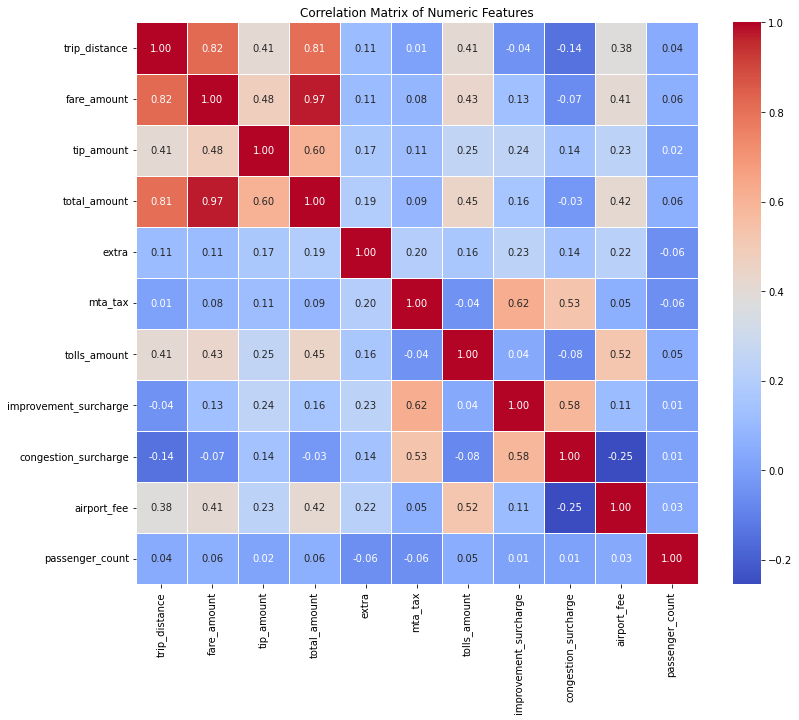

In [0]:
# Convert a sample of the DataFrame to Pandas for correlation analysis
numeric_sample_df = df.select(numeric_cols).dropna().sample(fraction=0.1, seed=42).toPandas()

# Compute the correlation matrix
correlation_matrix = numeric_sample_df.corr(method="spearman")

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, square=True)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

### 📊 EDA Summary: **Numeric Feature Correlations**

- **Top Positive Correlations:**
  - `fare_amount` is **strongly correlated** with both `trip_distance` *(r = 0.82)* and `total_amount` *(r = 0.97)*.
  - `tip_amount` and `tolls_amount` also show moderate positive correlations with `fare_amount`.

- **Surcharge Relationships:**
  - `mta_tax`, `improvement_surcharge`, and `congestion_surcharge` are **moderately interrelated**, likely due to shared trip conditions or regulations.
  
- **Low or Negligible Correlations:**
  - `passenger_count` shows **no meaningful correlation** with other features.
  - Weak negative correlation between `trip_distance` and `congestion_surcharge` may indicate shorter trips are more affected by congestion.

---

### ✅ Preprocessing Plan

- Be cautious of **multicollinearity**
- Consider engineering **normalized features**, such as:
  - `fare_per_mile = fare_amount / trip_distance`
  - `tip_ratio = tip_amount / fare_amount`
- Exclude or merge **redundant features** to improve model performance.

## Categorical vs Categorical

In [0]:
categorical= ["VendorID","RatecodeID","store_and_fwd_flag","payment_type","PULocationID","DOLocationID"]

In [0]:
cat_cols = [col for col in categorical if sample_df[col].nunique() <= 20]

In [0]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

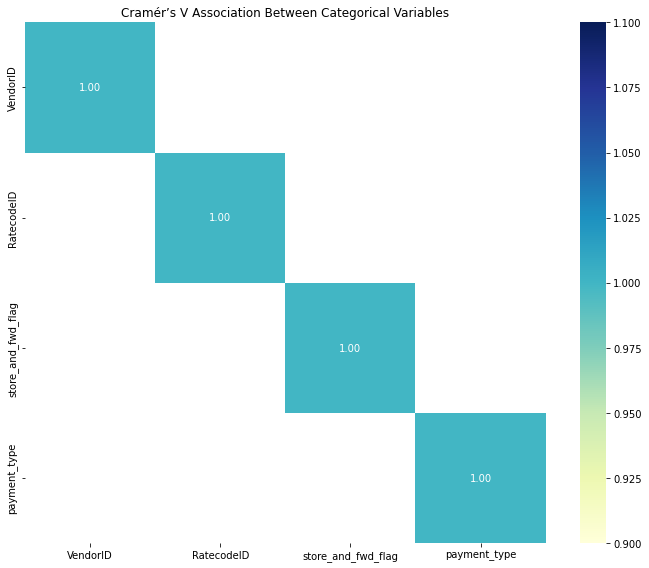

In [0]:
cramer_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)

for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 == col2:
            cramer_matrix.loc[col1, col2] = 1.0
        else:
            try:
                cramer_matrix.loc[col1, col2] = cramers_v(sample_df[col1], sample_df[col2])
            except:
                cramer_matrix.loc[col1, col2] = np.nan

cramer_matrix = cramer_matrix.astype(float)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cramer_matrix, annot=True, cmap="YlGnBu", fmt=".2f", square=True)
plt.title("Cramér’s V Association Between Categorical Variables")
plt.tight_layout()
plt.show()

### 📘 Interpretation: Cramér’s V Association Between Categorical Variables

Cramér’s V is designed to detect association patterns between categorical variables, and low values here indicate no strong relationship between them.

The heatmap shows that the categorical variables have **no significant association** with each other — as expected, the diagonal contains `1.00` values (each variable is perfectly associated with itself), while all off-diagonal values are near zero.

This result suggests that variables are **statistically independent** in this dataset. The values of one variable do **not influence or depend** on the values of another.

## Numerical vs Categorical

In [0]:
from sklearn.feature_selection import f_classif

def eta_squared(df, num_col, cat_col):
    groups = df[cat_col].astype(str)
    target = df[num_col]
    f, p = f_classif(pd.get_dummies(groups), target)
    return f[0] / (f[0] + df.shape[0] - 1)

In [0]:
results = []

for cat in categorical:
    for num in numerical:
        try:
            score = eta_squared(sample_df.dropna(subset=[cat, num]), num, cat)
            results.append((cat, num, round(score, 3)))
        except:
            results.append((cat, num, None))

eta_df = pd.DataFrame(results, columns=["Categorical", "Numerical", "Eta²"])
display(eta_df)


# Save de Dataset

In [0]:
full_df.write.mode("overwrite").parquet("dbfs:/FileStore/parquets/full_dataset_after_eda.parquet")